In [2]:
from utils import get_settings, read_video, save_video

import cv2
import numpy as np
from Tracker import ObjectTracker, KeypointTracker
from TeamAssigner import TeamAssigner, Team
from supervision import Color
from ViewTransformer import ViewTransformer
from BallAssigner import BallPlayerAssigner
# from SpeedEstimator import SpeedEstimator
from VideoProcessor import FootballVideoProcessor
from Annotator import  KeypointAnnotator, ProjectionAnnotator #, ObjectAnnotator

ValidationError: 8 validation errors for Settings
PITCH_WIDTH
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='6800    # Real field width = 68 meters', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
PITCH_LENGTH
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='10500  # Real field length = 105 meters', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
PITCH_PENALTY_BOX_WIDTH
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='4050  # Adjusted based o...os (around 40.5 meters)', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
PITCH_PENALTY_BOX_LENGTH
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='1650 # Adjusted based on...os (around 16.5 meters)', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
PITCH_GOAL_BOX_WIDTH
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='1830     # Actual size = 18.32 meters (1832 cm)', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
PITCH_GOAL_BOX_LENGTH
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='550     # Goal box depth = 5.5 meters (550 cm)', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
PITCH_CENTER_CIRCLE_RADIUS
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='915  # Actual size = 9.15 meters', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing
PITCH_PENALTY_SPOT_DISTANCE
  Input should be a valid integer, unable to parse string as an integer [type=int_parsing, input_value='1100  # Actual distance ...t = 11 meters (1100 cm)', input_type=str]
    For further information visit https://errors.pydantic.dev/2.9/v/int_parsing

In [1]:
settings = get_settings()

# Read Video
input_video_folder = settings.INPUT_VIDEO_PATH
input_video_name = settings.INPUT_VIDEO_NAME
input_video_path = input_video_folder + input_video_name

video_frames, fps = read_video(input_video_path)

NameError: name 'get_settings' is not defined

In [3]:
from Annotator import BaseAnnotator, EllipseAnnotator, TriangleAnnotator, LabelAnnotator
from Enums import Position
from utils import Settings

from supervision import Color, ColorPalette
from numpy import ndarray
from typing import Dict, List

class ObjectAnnotator(BaseAnnotator):
    """Annotates objects in a frame, such as the ball, players, referees, and goalkeepers."""

    def __init__(self, settings: Settings) -> None:
        """
        Initializes the ObjectAnnotator with predefined ball and referee annotation colors.
        """
        super().__init__()
        self.settings = settings

        if isinstance(settings.BALL_ANNOTATION_COLOR, List):
            triangle_color = ColorPalette.from_hex(settings.BALL_ANNOTATION_COLOR)
        else:
            triangle_color = Color.from_hex(settings.BALL_ANNOTATION_COLOR)
        
        self.triangle_annotator = TriangleAnnotator(
            color=triangle_color,
            base=25,
            height=21,
            outline_thickness=1,
            outline_color=Color.BLACK,
            classes=['ball', 'players']
        )   
        
        if isinstance(settings.OBJECT_ANNOTATION_COLOR, List):
            ellipse_color = ColorPalette.from_hex(settings.OBJECT_ANNOTATION_COLOR)
        else:
            ellipse_color = Color.from_hex(settings.OBJECT_ANNOTATION_COLOR)

        self.ellipse_annotator = EllipseAnnotator(
            color=ellipse_color,
            thickness=2
        )
        
        if isinstance(settings.LABEL_ANNOTATION_COLOR, List):
            label_color = ColorPalette.from_hex(settings.LABEL_ANNOTATION_COLOR)
        else:
            label_color = Color.from_hex(settings.LABEL_ANNOTATION_COLOR)
        
        if isinstance(settings.TEXT_ANNOTATION_COLOR, List):
            text_color = ColorPalette.from_hex(settings.TEXT_ANNOTATION_COLOR)
        else:
            text_color = Color.from_hex(settings.TEXT_ANNOTATION_COLOR)

        self.label_annotator = LabelAnnotator(
            color=label_color,
            text_color=text_color,
            text_position=Position.BOTTOM_CENTER,
        )
        
    def annotate(self, frame: ndarray, tracks: Dict) -> ndarray:
        """
        Annotates the frame with objects like players, referees, and the ball.

        Args:
            frame (ndarray): The current frame to be annotated.
            tracks (Dict): A dictionary containing object tracking data, categorized by object types.

        Returns:
            ndarray: The annotated frame.
        """
        frame = frame.copy()

        # Iterate over the tracked objects
        for track in tracks:
            for track_id, item in tracks[track].items():

                if track == 'ball':
                    frame = self.triangle_annotator.draw(frame, item['bbox'],obj_cls='ball')
                elif track == 'referees':
                    frame = self.ellipse_annotator.draw(frame, item['bbox'], type='Dashed')
                else:
                    speed = item.get('speed', 0)
                    team_color = item.get('team_color', None)

                    if track == 'players':
                        frame = self.ellipse_annotator.draw(frame, item['bbox'], type='Normal', color=team_color)
                    else:
                        frame = self.ellipse_annotator.draw(frame, item['bbox'], type='Double', color=team_color)   
                    
                    # If the player has the ball, draw a triangle to indicate it
                    if 'has_ball' in item and item['has_ball']:
                        frame = self.triangle_annotator.draw(frame, item['bbox'],obj_cls='players', color=Color.from_hex(self.settings.PLAYER_BALL_ANNOTATION_COLOR))

                    labels = [str(track_id)]
                    
                    frame = self.label_annotator.draw(frame, item['bbox'], labels, color=team_color, posistion=Position.BOTTOM_CENTER, background=True)

                    if speed >= 0:
                        labels = [f"{speed:.2f} km/h"]

                        frame = self.label_annotator.draw(frame, item['bbox'], labels, posistion=Position.TOP_RIGHT, background=False)

                   
        return frame
    

In [144]:
import math
from collections import deque
from typing import Dict, Any, Tuple

class SpeedEstimator:
    """Estimates the speed of objects (km/h)."""

    def __init__(self,
                 field_image_width: int = 800,
                 field_image_height: int = 1300,
                 real_field_length: float = 105,  # in meters (FIFA standard length)
                 real_field_width: float = 68,    # in meters (FIFA standard width)
                 smoothing_window: int = 5,
                 fps: int = 24) -> None:
        """
        Initialize the SpeedEstimator with the field dimensions and real-world measurements.

        Args:
            field_image_width (int): Width of the field in pixels.
            field_image_height (int): Height of the field in pixels.
            real_field_length (float): Real-world length of the field in meters.
            real_field_width (float): Real-world width of the field in meters.
            smoothing_window (int): Number of frames to consider for speed smoothing.
            fps (int): Frames per second of the video.
        """
        self.field_image_width = field_image_width
        self.field_image_height = field_image_height

        self.real_field_length = real_field_length  # in meters
        self.real_field_width = real_field_width    # in meters

        self.previous_positions: Dict[int, Tuple[Tuple[float, float], int]] = {}  # player_id -> (position, frame_number)

        self.speed_history: Dict[int, deque] = {}  # player_id -> deque of last window_size speeds for smoothing

        self.smoothing_window = smoothing_window

        self.fps = fps

        # Calculate scaling factors (pixels to meters conversion)
        self.scale_x = real_field_length / field_image_width
        self.scale_y = real_field_width / field_image_height

        # Maximum realistic speed (km/h)
        self.max_speed = 40.0

    def calculate_speed(self, tracks: Dict[str, Dict[int, Dict[str, Any]]], frame_number: int) -> Dict[str, Dict[int, Dict[str, Any]]]:
        """
        Calculate the speed of players based on their projections and update the track information.

        Args:
            tracks (Dict[str, Dict[int, Dict[str, Any]]]): A dictionary containing tracking information for players.
            frame_number (int): The current frame number of the video.

        Returns:
            Dict[str, Dict[int, Dict[str, Any]]]: Updated tracks with calculated speeds.
        """
        for track_type in tracks:

            if track_type == 'ball' or track_type == 'referees':
                continue  # Skip ball and referee speed calculations

            for player_id, track in tracks[track_type].items():
                if 'projection' in track:
                    current_position = track['projection']  # The player's current position (x, y)

                    if player_id in self.previous_positions:
                        prev_position, prev_frame = self.previous_positions[player_id]

                        # Calculate the distance in meters
                        distance = self._calculate_distance(prev_position, current_position)/20

                        # Calculate the time difference in seconds
                        time_diff = (frame_number - prev_frame) / self.fps

                        # Prevent division by zero
                        if time_diff <= 0:
                            time_diff = 1 / self.fps

                        # Calculate speed in km/h
                        speed = (distance / time_diff) * 3.6  # Convert m/s to km/h

                        # Apply maximum speed check
                        speed = min(speed, self.max_speed)

                        # Apply smoothing to speed
                        smoothed_speed = self._smooth_speed(player_id, speed)

                        # Update the player's speed and distance in the track
                        tracks[track_type][player_id]['speed'] = smoothed_speed
                        tracks[track_type][player_id]['distance'] = distance

                        # Debugging: Print values to understand what's happening
                        print(f"Player {player_id} - Distance: {distance:.2f} meters, "
                              f"Time: {time_diff:.2f} seconds, Raw Speed: {speed:.2f} km/h")
                        print(f"Player {player_id} - Smoothed Speed: {smoothed_speed:.2f} km/h")

                    else:
                        # If it's the first time we're seeing this player, set speed to 0
                        tracks[track_type][player_id]['speed'] = 0.0
                        tracks[track_type][player_id]['distance'] = 0.0
                        self.speed_history[player_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)

                    # Update the previous position with the current position and frame number
                    self.previous_positions[player_id] = (current_position, frame_number)
                else:
                    # If there's no projection, set speed to 0
                    tracks[track_type][player_id]['speed'] = 0.0
                    tracks[track_type][player_id]['distance'] = 0.0

        return tracks

    def _calculate_distance(self, pos1: Tuple[float, float], pos2: Tuple[float, float]) -> float:
        """
        Calculate the Euclidean distance between two positions in meters.

        Args:
            pos1 (Tuple[float, float]): The first position (x, y) in pixels.
            pos2 (Tuple[float, float]): The second position (x, y) in pixels.

        Returns:
            float: The distance in meters.
        """
        dx = (pos2[0] - pos1[0]) * self.scale_x
        dy = (pos2[1] - pos1[1]) * self.scale_y
        return math.sqrt(dx**2 + dy**2)

    def _smooth_speed(self, player_id: Any, speed: float) -> float:
        """
        Smooth the speed measurement using a moving average.

        Args:
            player_id (Any): The identifier for the player.
            speed (float): The calculated speed to be smoothed.

        Returns:
            float: The smoothed speed value.
        """
        if player_id not in self.speed_history:
            self.speed_history[player_id] = deque([0.0] * self.smoothing_window, maxlen=self.smoothing_window)

        self.speed_history[player_id].append(speed)
        return sum(self.speed_history[player_id]) / len(self.speed_history[player_id])

    def reset(self) -> None:
        """
        Reset the previous positions and speed history. 
        Call this at the start of a new video or when needed.
        """
        self.previous_positions = {}
        self.speed_history = {}


In [4]:
# Initialize Trackers
object_tracker = ObjectTracker('models\weights\object-detection_yolo_v8.pt')
keypoints_tracker = KeypointTracker('models\weights\keypoints-detection_yolo_v8.pt')

# Intialize Team Assigner
team1 = Team('team1', Color.from_hex(settings.OBJECT_ANNOTATION_COLOR[0]), Color.from_hex(settings.OBJECT_ANNOTATION_COLOR[0]))
team2 = Team('team2', Color.from_hex(settings.OBJECT_ANNOTATION_COLOR[1]), Color.from_hex(settings.OBJECT_ANNOTATION_COLOR[1]))
team_assigner = TeamAssigner(team1=team1, team2=team2, settings=settings)

# Initialize View Transformer
transformer = ViewTransformer(top_down_keypoints=np.array(settings.vertices()), alpha=0.7)

# Initialize Ball Player Assigner
ball_player_assigner = BallPlayerAssigner(team1=team1, team2=team2, fps=fps)



# Initialize Annotators
object_annotator = ObjectAnnotator(settings)
keypoints_annotator = KeypointAnnotator(settings)
projection_annotator = ProjectionAnnotator(settings, team1, team2)


NameError: name 'ObjectTracker' is not defined

In [6]:
object_detections = object_tracker.get_detections(video_frames, read_from_stub=True,stub_name=input_video_name)
keypoints_detections = keypoints_tracker.get_detections(video_frames, read_from_stub=True,stub_name=input_video_name)


In [7]:
object_tracks = object_tracker.get_tracks(detections=object_detections)
keypoints_tracks, filters = keypoints_tracker.get_tracks(detections=keypoints_detections)

In [8]:
team_assigner.fit(frames=video_frames, all_tracks=object_tracks)

In [145]:
# Initialize Speed Estimator
speed_estimator = SpeedEstimator(
    field_image_width=800,
    field_image_height=1300,
    real_field_length=100,
    real_field_width=50,
    smoothing_window=5,
    fps=fps
)

In [152]:
idx = 155

In [153]:
frame_object_tracks = object_tracks[idx]
frame_keypoints_tracks = keypoints_tracks[idx]

In [154]:
frame_tracks = {
    'object_tracks': frame_object_tracks,
    'keypoints_tracks': frame_keypoints_tracks
}

# Assign Player Teams
frame_tracks['object_tracks'] = team_assigner.assign_teams(video_frames[idx], frame_object_tracks)

# Transform to top-down view
frame_tracks['object_tracks'] = transformer.transform(object_tracks=frame_tracks['object_tracks'], keypoints_tracks=frame_tracks['keypoints_tracks'], filter=filters[idx])


In [155]:
point1, point2 = None, None
for key, val in enumerate(frame_tracks['keypoints_tracks'].xy[0]):
    if key == 8:
        point1 = (val[0], val[1])
    elif key == 24:
        point2 = (val[0], val[1])
    else:
        continue
# Assign Ball to closest Player
frame_tracks['object_tracks'], _ = ball_player_assigner.assign(
    tracks=frame_tracks['object_tracks'],
    current_frame=idx,
    penalty_point_1_pos=point1, # keypoint for player 1
    penalty_point_2_pos=point2  # keypoint for player 2
)

In [156]:
# Speed Estimation for Players
frame_tracks['object_tracks'] = speed_estimator.calculate_speed(
    tracks=frame_tracks['object_tracks'],
    frame_number=idx,
)


Player 19 - Distance: 0.10 meters, Time: 0.04 seconds, Raw Speed: 9.20 km/h
Player 19 - Smoothed Speed: 1.84 km/h
Player 18 - Distance: 0.03 meters, Time: 0.04 seconds, Raw Speed: 2.81 km/h
Player 18 - Smoothed Speed: 0.56 km/h
Player 5 - Distance: 0.01 meters, Time: 0.04 seconds, Raw Speed: 1.12 km/h
Player 5 - Smoothed Speed: 0.22 km/h
Player 10 - Distance: 0.07 meters, Time: 0.04 seconds, Raw Speed: 6.51 km/h
Player 10 - Smoothed Speed: 1.30 km/h
Player 3 - Distance: 0.15 meters, Time: 0.04 seconds, Raw Speed: 13.71 km/h
Player 3 - Smoothed Speed: 2.74 km/h
Player 45 - Distance: 0.12 meters, Time: 0.04 seconds, Raw Speed: 10.55 km/h
Player 45 - Smoothed Speed: 2.11 km/h
Player 13 - Distance: 0.09 meters, Time: 0.04 seconds, Raw Speed: 8.27 km/h
Player 13 - Smoothed Speed: 1.65 km/h
Player 12 - Distance: 0.03 meters, Time: 0.04 seconds, Raw Speed: 3.08 km/h
Player 12 - Smoothed Speed: 0.62 km/h
Player 11 - Distance: 0.10 meters, Time: 0.04 seconds, Raw Speed: 9.29 km/h
Player 11 - Sm

In [151]:
frame = video_frames[idx]
tracks = frame_tracks['object_tracks']

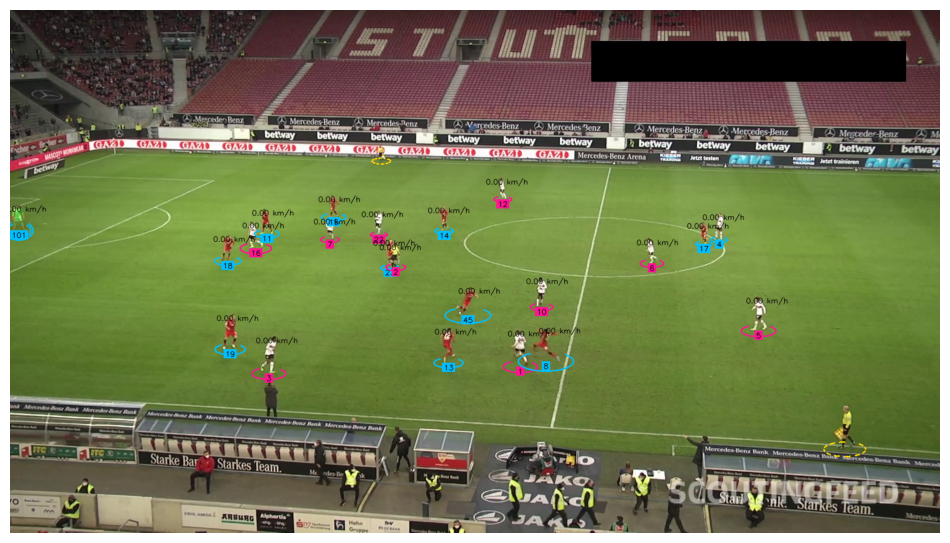

In [138]:
import supervision as sv

frame = object_annotator.annotate(frame, tracks)
sv.plot_image(frame)

In [14]:
from Annotator import ProjectionAnnotator
projection_annotator = ProjectionAnnotator(settings, team1, team2)

In [15]:
annoteted_frame, voronoi_frame, blended_frame, frame = projection_annotator.annotate(frame, tracks)

TypeError: array() got an unexpected keyword argument 'pitch_ball_xy'

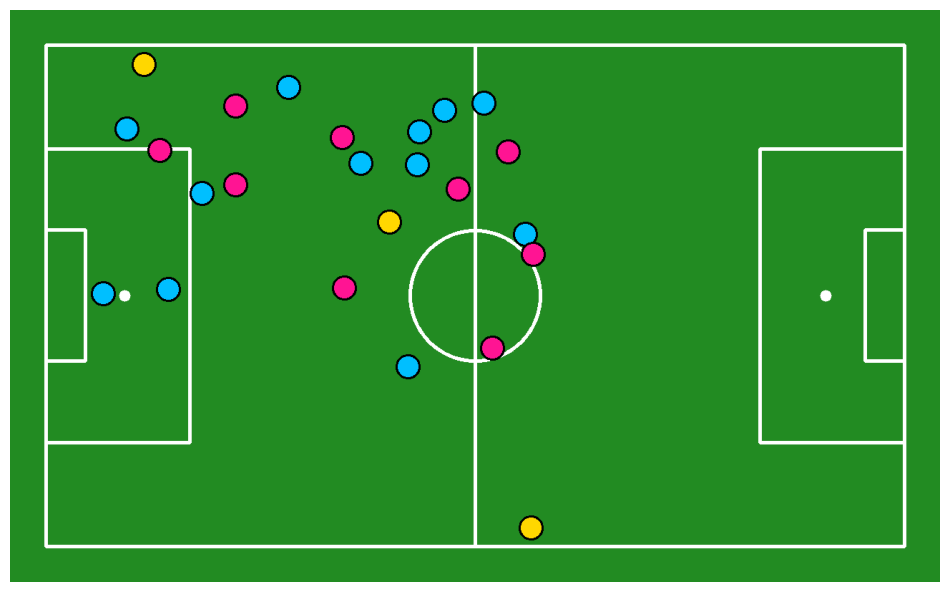

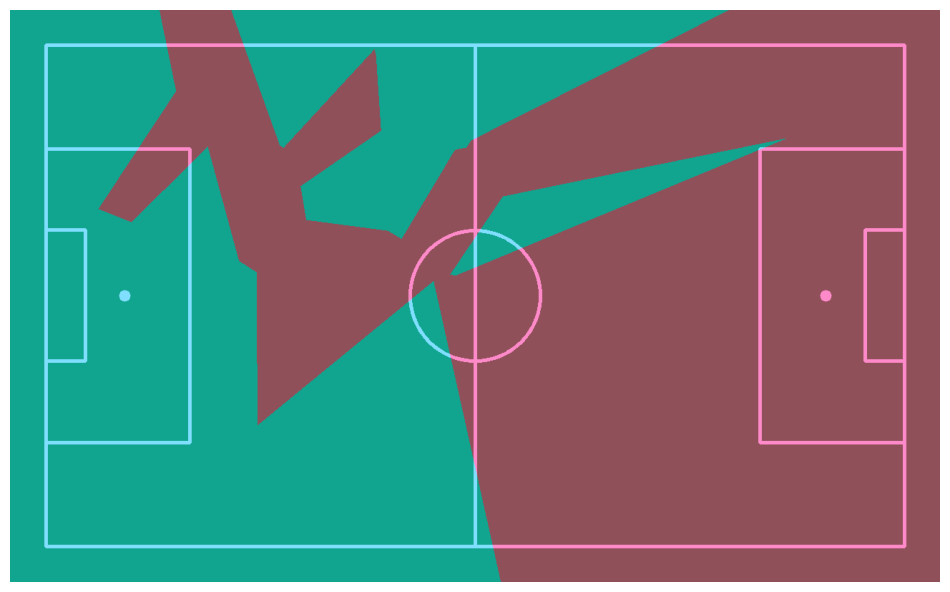

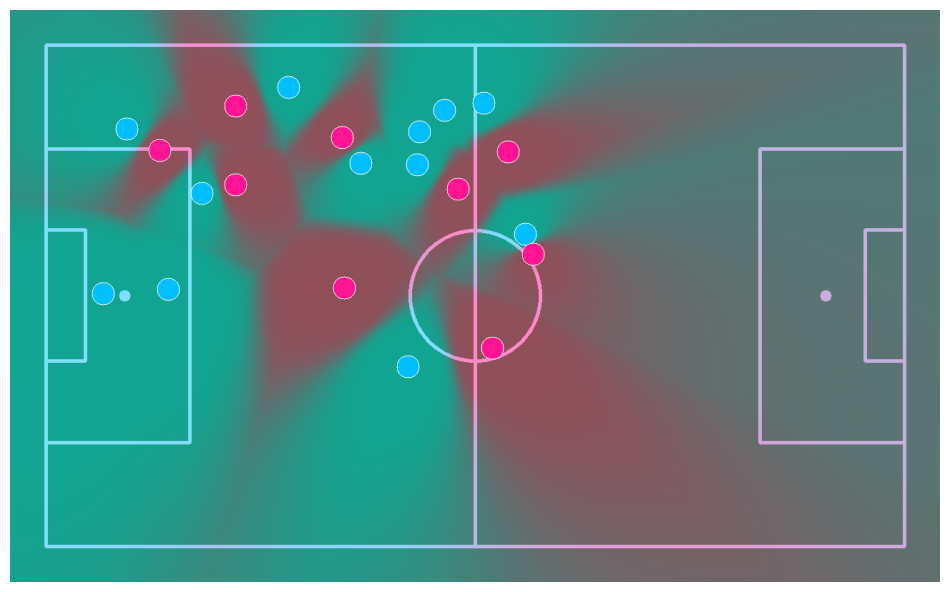

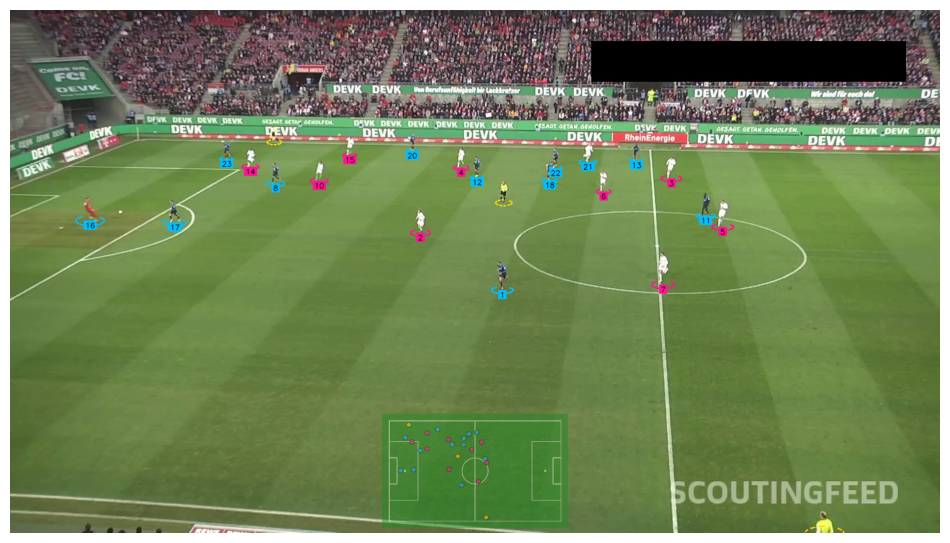

In [13]:
sv.plot_image(annoteted_frame)
sv.plot_image(voronoi_frame)
sv.plot_image(blended_frame)
sv.plot_image(frame)

In [10]:
pitch_ball_xy = None
if 1 in tracks['ball']:
    pitch_ball_xy = tracks['ball'][1]['projection']

In [11]:
print(pitch_ball_xy)

None


In [12]:
pitch_referee_xy = np.array([track['projection'] for track in tracks['referees'].values()])
pitch_player_team1_xy = np.array([track['projection'] for track in tracks['players'].values() if track['team'] == team1.name])
pitch_player_team2_xy = np.array([track['projection'] for track in tracks['players'].values() if track['team'] == team2.name])


In [13]:
goalkeepers_team1 = np.array([track['projection'] for track in tracks['goalkeepers'].values() if track['team'] == team1.name])
goalkeepers_team2 = np.array([track['projection'] for track in tracks['goalkeepers'].values() if track['team'] == team2.name])

In [14]:
arrays_to_concat = [pitch_player_team1_xy]
if goalkeepers_team1.size > 0:
    arrays_to_concat.append(goalkeepers_team1)

pitch_player_team1_xy = np.concatenate(arrays_to_concat)

arrays_to_concat = [pitch_player_team2_xy]
if goalkeepers_team2.size > 0:
    arrays_to_concat.append(goalkeepers_team2)
pitch_player_team2_xy = np.concatenate(arrays_to_concat)

In [18]:
pitch_referee_xy

array([[       9720,      3127.3],
       [     3235.7,      4629.4],
       [     1332.7,      3612.9]])

In [23]:
import supervision as sv
def _draw_pitch(
            background_color: sv.Color = sv.Color(34, 139, 34),
            line_color: sv.Color = sv.Color.WHITE,
            padding: int = 50,
            line_thickness: int = 4,
            point_radius: int = 8,
            scale: float = 0.1) -> np.ndarray:
    """
    Draws a soccer pitch with specified dimensions, colors, and scale.

    Args:
        settings (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        background_color (sv.Color, optional): Color of the pitch background.
            Defaults to sv.Color(34, 139, 34).
        line_color (sv.Color, optional): Color of the pitch lines.
            Defaults to sv.Color.WHITE.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        line_thickness (int, optional): Thickness of the pitch lines in pixels.
            Defaults to 4.
        point_radius (int, optional): Radius of the penalty spot points in pixels.
            Defaults to 8.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.

    Returns:
        np.ndarray: Image of the soccer pitch.
    """
    scaled_width = int(settings.PITCH_WIDTH * scale)
    scaled_length = int(settings.PITCH_LENGTH * scale)
    scaled_circle_radius = int(settings.PITCH_CENTER_CIRCLE_RADIUS * scale)
    scaled_penalty_spot_distance = int(settings.PITCH_PENALTY_SPOT_DISTANCE * scale)

    pitch_width = scaled_width + 2 * padding
    pitch_length = scaled_length + 2 * padding
    pitch_shape = (pitch_width, pitch_length, 3)
    pitch_image = np.ones(pitch_shape,dtype=np.uint8) * np.array(background_color.as_bgr(), dtype=np.uint8)

    for start, end in settings.edges:

        point1 = (int(settings.vertices()[start - 1][0] * scale) + padding,
                int(settings.vertices()[start - 1][1] * scale) + padding)
        
        point2 = (int(settings.vertices()[end - 1][0] * scale) + padding,
                int(settings.vertices()[end - 1][1] * scale) + padding)
        
        cv2.line(
            img=pitch_image,
            pt1=point1,
            pt2=point2,
            color=line_color.as_bgr(),
            thickness=line_thickness
        )

    centre_circle_center = ( scaled_length // 2 + padding, scaled_width // 2 + padding)

    cv2.circle(
        img=pitch_image,
        center=centre_circle_center,
        radius=scaled_circle_radius,
        color=line_color.as_bgr(),
        thickness=line_thickness
    )

    penalty_spots = [
        (scaled_penalty_spot_distance + padding,scaled_width // 2 + padding),
        
        (scaled_length - scaled_penalty_spot_distance + padding, scaled_width // 2 + padding)
    ]

    for spot in penalty_spots:

        cv2.circle(
            img=pitch_image,
            center=spot,
            radius=point_radius,
            color=line_color.as_bgr(),
            thickness=-1
        )

    return pitch_image


In [17]:
import supervision as sv
xy=pitch_player_team1_xy
face_color= sv.Color.RED
edge_color= sv.Color.BLACK
radius= 10
thickness= 2
padding= 50
scale= 0.1
pitch = _draw_pitch(padding=padding, scale=scale)

NameError: name 'pitch_player_team1_xy' is not defined

In [23]:
if xy is None or len(xy) == 0:
    print('No player positions to draw')

if pitch is None:
    pitch =_draw_pitch(padding=padding,scale=scale)

In [24]:
for point in xy:

    scaled_point = ( int(point[0] * scale) + padding, int(point[1] * scale) + padding)
    
    cv2.circle(
        img=pitch,
        center=scaled_point,
        radius=radius,
        color=face_color.as_bgr(),
        thickness=-1
    )

    cv2.circle(
        img=pitch,
        center=scaled_point,
        radius=radius,
        color=edge_color.as_bgr(),
        thickness=thickness
    )

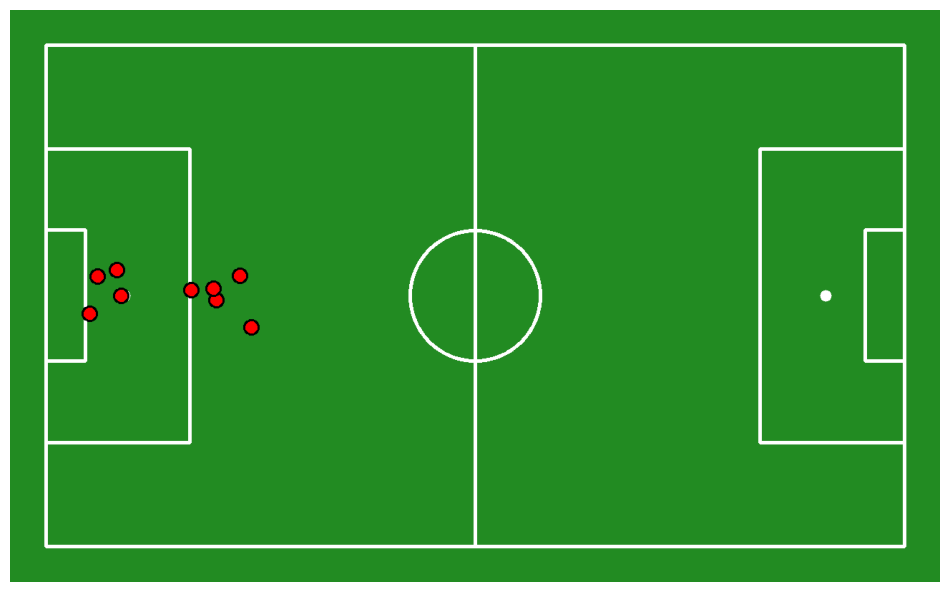

In [26]:
sv.plot_image(pitch)

In [21]:
from typing import Optional


def _draw_points_on_pitch(
                        xy: np.ndarray,
                        face_color: sv.Color = sv.Color.RED,
                        edge_color: sv.Color = sv.Color.BLACK,
                        radius: int = 10,
                        thickness: int = 2,
                        padding: int = 50,
                        scale: float = 0.1,
                        pitch: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Draws points on a soccer pitch.

    Args:
        xy (np.ndarray): Array of points to be drawn, with each point represented by
            its (x, y) coordinates.
        face_color (sv.Color, optional): Color of the point faces.
            Defaults to sv.Color.RED.
        edge_color (sv.Color, optional): Color of the point edges.
            Defaults to sv.Color.BLACK.
        radius (int, optional): Radius of the points in pixels.
            Defaults to 10.
        thickness (int, optional): Thickness of the point edges in pixels.
            Defaults to 2.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw points on.
            If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with points drawn on it.
    """
    if xy is None or len(xy) == 0:
        return pitch

    if pitch is None:
        pitch = _draw_pitch(padding=padding,scale=scale)

    for point in xy:

        scaled_point = ( int(point[0] * scale) + padding, int(point[1] * scale) + padding)
        
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=face_color.as_bgr(),
            thickness=-1
        )

        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=edge_color.as_bgr(),
            thickness=thickness
        )

    return pitch

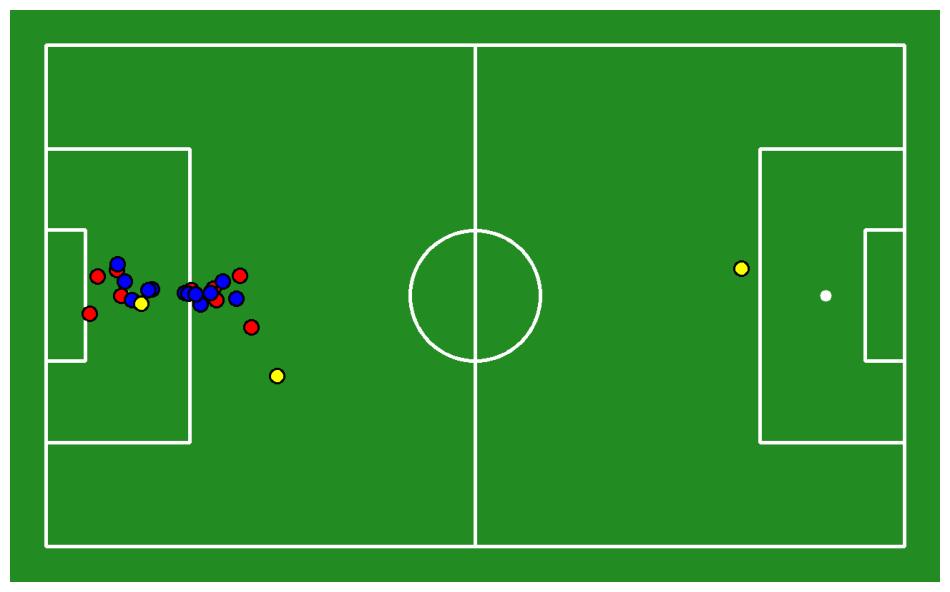

In [31]:
pitch = _draw_points_on_pitch(xy=pitch_referee_xy, face_color=sv.Color.YELLOW, pitch=pitch)
sv.plot_image(pitch)

In [32]:
pitch.shape

(800, 1300, 3)

In [34]:
key_points = sv.KeyPoints.from_ultralytics(keypoints_detections[0])
filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(settings.vertices())[filter]

In [35]:
from sports.common.view import ViewTransformer

transformer = ViewTransformer(source=frame_reference_points, target=pitch_reference_points)

In [36]:
from utils import get_anchors_coordinates
from Enums import Position


for class_name, track_data in object_tracks[0].items():
    for track_id, track_info in track_data.items():
        bbox = track_info['bbox']
        feet_pos = get_anchors_coordinates(bbox,anchor=Position.BOTTOM_CENTER)
        projected_pos = transformer.transform_points(np.array([feet_pos]))[0]
        object_tracks[0][class_name][track_id]['projection'] = projected_pos

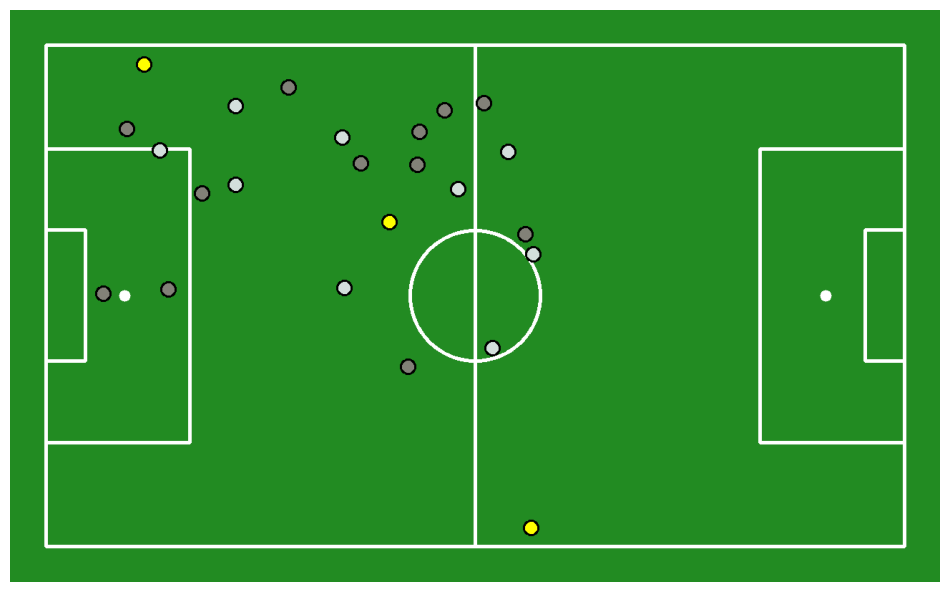

In [54]:
tracks = object_tracks[0]
frame = video_frames[0]

pitch_referee_xy = np.array([track['projection'] for track in tracks['referees'].values()])
pitch_player_team1_xy = np.array([track['projection'] for track in tracks['players'].values() if track['team'] == team1.name])
pitch_player_team2_xy = np.array([track['projection'] for track in tracks['players'].values() if track['team'] == team2.name])

goalkeepers_team1 = np.array([track['projection'] for track in tracks['goalkeepers'].values() if track['team'] == team1.name])
goalkeepers_team2 = np.array([track['projection'] for track in tracks['goalkeepers'].values() if track['team'] == team2.name])

arrays_to_concat = [pitch_player_team1_xy]
if goalkeepers_team1.size > 0:
    arrays_to_concat.append(goalkeepers_team1)

pitch_player_team1_xy = np.concatenate(arrays_to_concat)

arrays_to_concat = [pitch_player_team2_xy]
if goalkeepers_team2.size > 0:
    arrays_to_concat.append(goalkeepers_team2)
pitch_player_team2_xy = np.concatenate(arrays_to_concat)

pitch = _draw_points_on_pitch(xy=pitch_ball_xy, face_color=sv.Color.WHITE)
pitch = _draw_points_on_pitch(xy=pitch_referee_xy, face_color=sv.Color.YELLOW)
pitch = _draw_points_on_pitch(xy=pitch_player_team1_xy, face_color=team1.player_jersey_color, pitch=pitch)
pitch = _draw_points_on_pitch(xy=pitch_player_team2_xy, face_color=team2.player_jersey_color, pitch=pitch)
sv.plot_image(pitch)

In [22]:
import supervision as sv
from typing import Optional

def _draw_pitch_voronoi_diagram(
                                    team_1_xy: np.ndarray,
                                    team_2_xy: np.ndarray,
                                    team_1_color: sv.Color = sv.Color.RED,
                                    team_2_color: sv.Color = sv.Color.WHITE,
                                    opacity: float = 0.5,
                                    padding: int = 50,
                                    scale: float = 0.1,
                                    pitch: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams.

    Args:
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = _draw_pitch(padding=padding,scale=scale)

    scaled_width = int(settings.PITCH_WIDTH * scale)
    scaled_length = int(settings.PITCH_LENGTH * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices(( scaled_width + 2 * padding, scaled_length + 2 * padding))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                    (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)


        

    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    control_mask = min_distances_team_1 < min_distances_team_2

    voronoi[control_mask] = team_1_color_bgr
    voronoi[~control_mask] = team_2_color_bgr

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

In [56]:
pitch = _draw_pitch_voronoi_diagram(team_1_xy=pitch_player_team1_xy, team_2_xy=pitch_player_team2_xy)

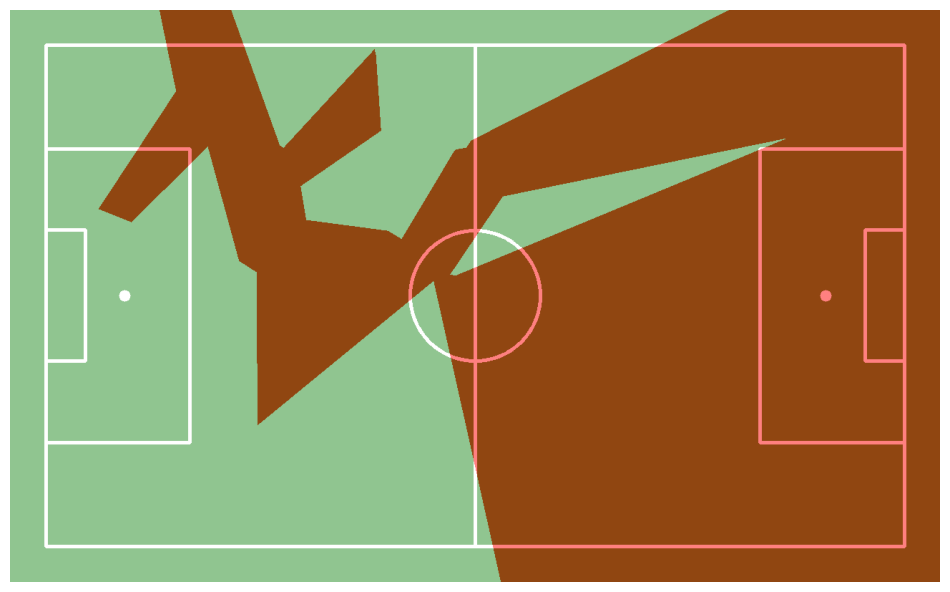

In [57]:
sv.plot_image(pitch)

In [14]:
def _draw_pitch_voronoi_diagram_2(
                                     team_1_xy: np.ndarray,
                                     team_2_xy: np.ndarray,
                                     team_1_color: sv.Color = sv.Color.RED,
                                     team_2_color: sv.Color = sv.Color.WHITE,
                                     opacity: float = 0.5,
                                     padding: int = 50,
                                     scale: float = 0.1,
                                     pitch: Optional[np.ndarray] = None) -> np.ndarray:
    """
    Draws a Voronoi diagram on a soccer pitch representing the control areas of two
    teams with smooth color transitions.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        team_1_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 1.
        team_2_xy (np.ndarray): Array of (x, y) coordinates representing the positions
            of players in team 2.
        team_1_color (sv.Color, optional): Color representing the control area of
            team 1. Defaults to sv.Color.RED.
        team_2_color (sv.Color, optional): Color representing the control area of
            team 2. Defaults to sv.Color.WHITE.
        opacity (float, optional): Opacity of the Voronoi diagram overlay.
            Defaults to 0.5.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw the
            Voronoi diagram on. If None, a new pitch will be created. Defaults to None.

    Returns:
        np.ndarray: Image of the soccer pitch with the Voronoi diagram overlay.
    """
    if pitch is None:
        pitch = _draw_pitch(padding=padding,scale=scale)

    scaled_width = int(settings.PITCH_WIDTH * scale)
    scaled_length = int(settings.PITCH_LENGTH * scale)

    voronoi = np.zeros_like(pitch, dtype=np.uint8)

    team_1_color_bgr = np.array(team_1_color.as_bgr(), dtype=np.uint8)
    team_2_color_bgr = np.array(team_2_color.as_bgr(), dtype=np.uint8)

    y_coordinates, x_coordinates = np.indices((scaled_width + 2*padding, scaled_length + 2*padding))

    y_coordinates -= padding
    x_coordinates -= padding

    def calculate_distances(xy, x_coordinates, y_coordinates):
        return np.sqrt((xy[:, 0][:, None, None] * scale - x_coordinates) ** 2 +
                    (xy[:, 1][:, None, None] * scale - y_coordinates) ** 2)
    
    distances_team_1 = calculate_distances(team_1_xy, x_coordinates, y_coordinates)
    distances_team_2 = calculate_distances(team_2_xy, x_coordinates, y_coordinates)

    min_distances_team_1 = np.min(distances_team_1, axis=0)
    min_distances_team_2 = np.min(distances_team_2, axis=0)

    # Increase steepness of the blend effect
    steepness = 15  # Increased steepness for sharper transition
    distance_ratio = min_distances_team_2 / np.clip(min_distances_team_1 + min_distances_team_2, a_min=1e-5, a_max=None)
    blend_factor = np.tanh((distance_ratio - 0.5) * steepness) * 0.5 + 0.5

    # Create the smooth color transition
    for c in range(3):  # Iterate over the B, G, R channels
        voronoi[:, :, c] = (blend_factor * team_1_color_bgr[c] +
                            (1 - blend_factor) * team_2_color_bgr[c]).astype(np.uint8)

    overlay = cv2.addWeighted(voronoi, opacity, pitch, 1 - opacity, 0)

    return overlay

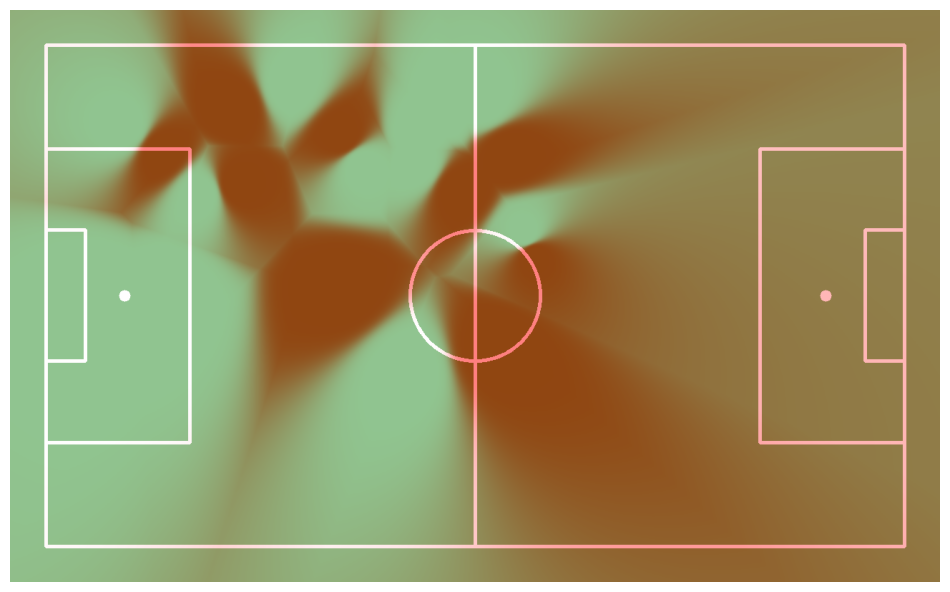

In [59]:
pitch = _draw_pitch_voronoi_diagram_2(team_1_xy=pitch_player_team1_xy, team_2_xy=pitch_player_team2_xy)
sv.plot_image(pitch)

In [15]:
def _overlay_minimap_on_frame(frame: np.ndarray, minimap: np.ndarray, opacity: float=0.5, scale: float=0.2):
    """
    Overlay the minimap image on the frame at the bottom center with a given opacity and scale.

    :param frame: The original frame (soccer game image), expected as a 3-channel RGB image.
    :param minimap: The mini-map image, either RGB or grayscale.
    :param opacity: The transparency level of the mini-map (0.0 to 1.0).
    :param scale: The scale factor to resize the mini-map (0.2 means 20% of the frame width).
    :return: The frame with the mini-map overlay.
    """
    # Get the dimensions of the frame
    frame_height, frame_width = frame.shape[:2]

    # Resize the mini-map to be smaller (bottom center) based on the scale of the frame width
    minimap_width = int(frame_width * scale)
    minimap_height = int(minimap.shape[0] * minimap_width / minimap.shape[1])
    minimap_resized = cv2.resize(minimap, (minimap_width, minimap_height))

    # Calculate the position (bottom center)
    x_offset = (frame_width - minimap_width) // 2  # Horizontally center the minimap
    y_offset = frame_height - minimap_height - 10  # Place it 10 pixels from the bottom

    # Extract the region of interest (ROI) from the frame where the mini-map will be placed
    roi = frame[y_offset:y_offset + minimap_height, x_offset:x_offset + minimap_width]

    # Convert minimap to have 3 channels if it's grayscale
    if len(minimap_resized.shape) == 2:
        minimap_resized = cv2.cvtColor(minimap_resized, cv2.COLOR_GRAY2BGR)

    # Blend the mini-map with the frame (overlay with opacity)
    blended = cv2.addWeighted(roi, 1 - opacity, minimap_resized, opacity, 0)

    # Replace the ROI on the original frame with the blended image
    frame[y_offset:y_offset + minimap_height, x_offset:x_offset + minimap_width] = blended

    return frame

In [62]:
annotated_frame = _draw_pitch()
voronoi_frame = _draw_pitch()
blended_frame = _draw_pitch()

# Draw Ball
annotated_frame = _draw_points_on_pitch(xy=pitch_ball_xy,
                                            face_color=sv.Color.WHITE,
                                            edge_color=sv.Color.BLACK,
                                            radius=10,
                                            pitch=annotated_frame)

# Draw Players Team 1
annotated_frame = _draw_points_on_pitch(xy=pitch_player_team1_xy,
                                            face_color=sv.Color.from_hex('00BFFF'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame)

# Draw Players Team 2
annotated_frame = _draw_points_on_pitch(xy=pitch_player_team2_xy,
                                            face_color=sv.Color.from_hex('FF1493'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame)

# Draw Referees
annotated_frame = _draw_points_on_pitch(xy=pitch_referee_xy,
                                            face_color=sv.Color.from_hex('FFD700'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame)

voronoi_frame = _draw_pitch_voronoi_diagram(team_1_xy=pitch_player_team1_xy,
                                                team_2_xy=pitch_player_team2_xy,
                                                team_1_color=sv.Color.from_hex('00BFFF'),
                                                team_2_color=sv.Color.from_hex('FF1493'),
                                                pitch=voronoi_frame)



blended_frame = _draw_pitch_voronoi_diagram_2(team_1_xy=pitch_player_team1_xy,
                                                        team_2_xy=pitch_player_team2_xy,
                                                        team_1_color=sv.Color.from_hex('00BFFF'),
                                                        team_2_color=sv.Color.from_hex('FF1493'),
                                                        pitch=blended_frame)

blended_frame = _draw_points_on_pitch(xy=pitch_ball_xy,
                                        face_color=sv.Color.WHITE,
                                        edge_color=sv.Color.WHITE,
                                        radius=8,
                                        thickness=1,
                                        pitch=blended_frame)

blended_frame = _draw_points_on_pitch(xy=pitch_player_team1_xy,
                                        face_color=sv.Color.from_hex('00BFFF'),
                                        edge_color=sv.Color.WHITE,
                                        radius=16,
                                        thickness=1,
                                        pitch=blended_frame)

blended_frame = _draw_points_on_pitch(xy=pitch_player_team2_xy,
                                                face_color=sv.Color.from_hex('FF1493'),
                                                edge_color=sv.Color.WHITE,
                                                radius=16,
                                                thickness=1,
                                                pitch=blended_frame)

original_frame = _overlay_minimap_on_frame(frame, annotated_frame, opacity=0.5, scale=0.2)

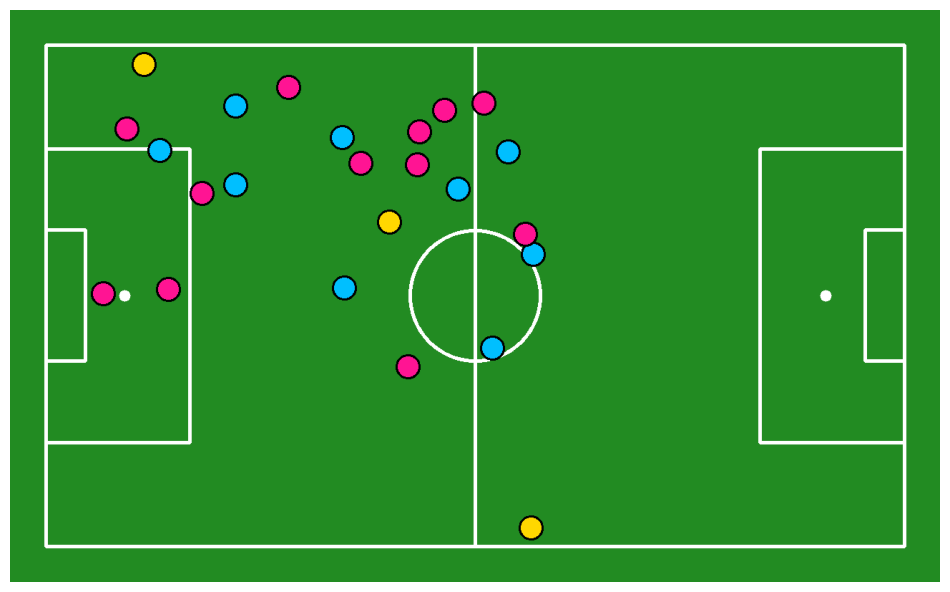

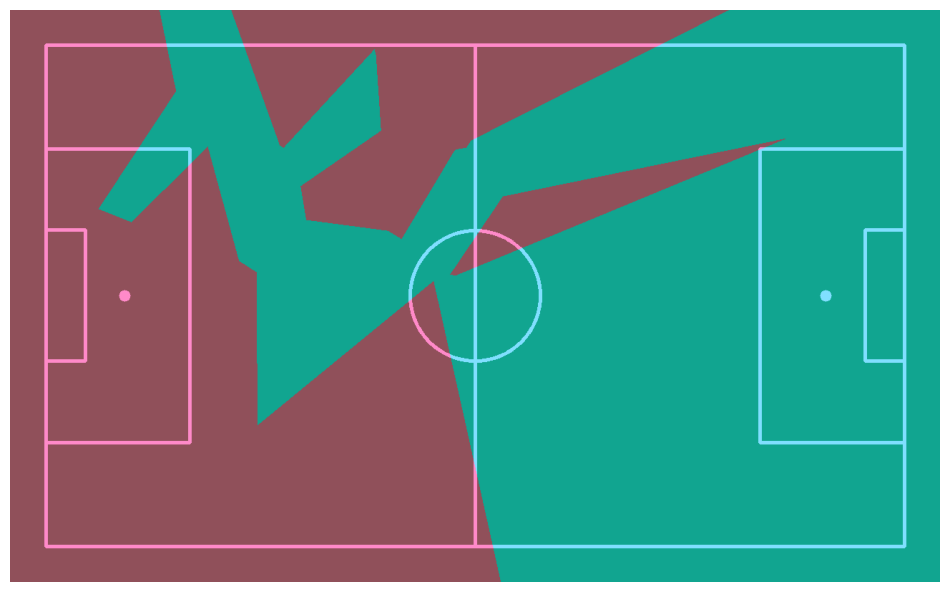

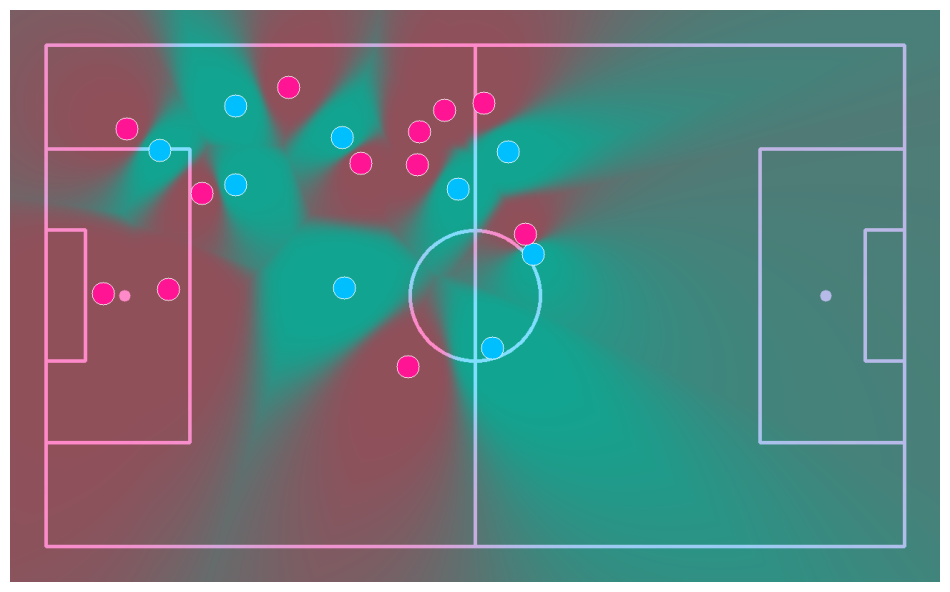

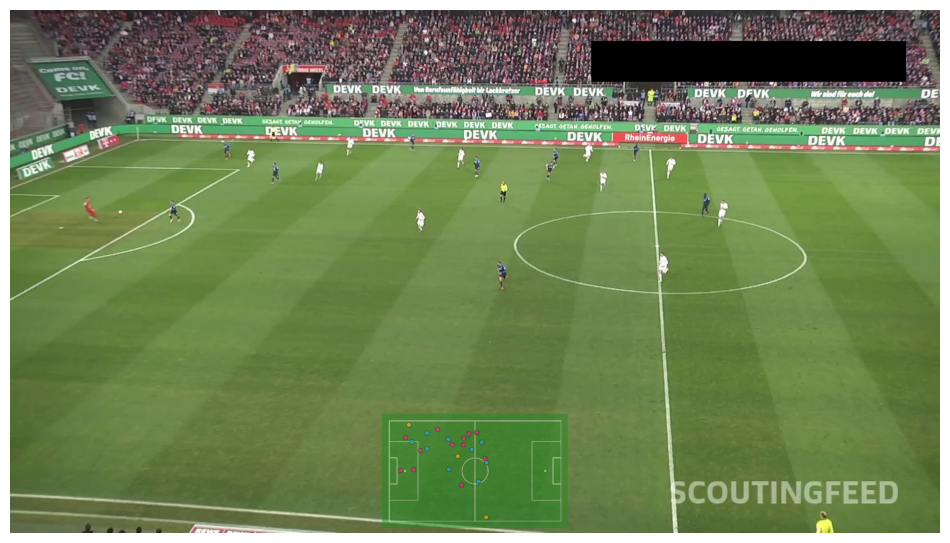

In [63]:
sv.plot_image(annotated_frame)
sv.plot_image(voronoi_frame)
sv.plot_image(blended_frame)
sv.plot_image(original_frame)

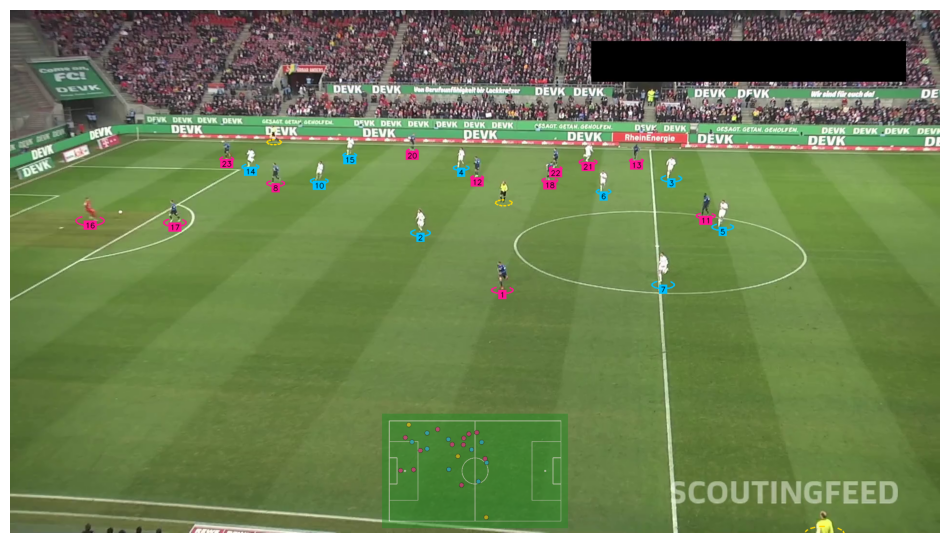

In [64]:
frame = object_annotator.annotate(video_frames[0], object_tracks[0])
sv.plot_image(frame)

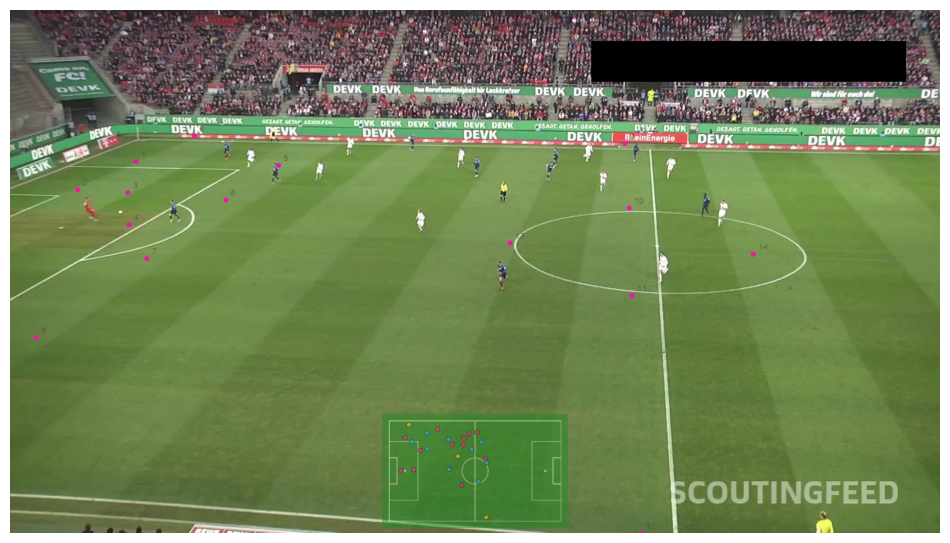

In [65]:
frame = keypoints_annotator.annotate(video_frames[0], keypoints_tracks[0])
sv.plot_image(frame)

In [66]:
# TO DO

# 1. View Transformer
# 2. Ball Player Assigner
# 3. Speed Estimator
# 4. Video Processor
# 5. README
# 6. .env


In [6]:
key_points_tracks, filters = keypoints_tracker.get_tracks(detections=keypoints_detections)

In [7]:
pitch_top_down_points = np.array(settings.vertices())[filters[0]]

In [8]:
from ViewTransformer import ViewTransformer

transformer = ViewTransformer(top_down_keypoints=np.array(settings.vertices()))

In [10]:
tracks = transformer.transform(object_tracks=object_tracks[0], keypoints_tracks=key_points_tracks[0], filter=filters[0])

In [23]:
all_tracks = {
    'object_tracks': object_tracks,
    'keypoints_tracks': key_points_tracks
}

In [25]:
team_assigner.fit(video_frames, object_tracks)
tracks = team_assigner.assign_teams(video_frames[0], tracks)

In [26]:
pitch_ball_xy = None
if 1 in tracks['ball']:
    pitch_ball_xy = tracks['ball'][1]['projection']

pitch_referee_xy = np.array([track['projection'] for track in tracks['referees'].values()])
pitch_player_team1_xy = np.array([track['projection'] for track in tracks['players'].values() if track['team'] == team1.name])
pitch_player_team2_xy = np.array([track['projection'] for track in tracks['players'].values() if track['team'] == team2.name])

goalkeepers_team1 = np.array([track['projection'] for track in tracks['goalkeepers'].values() if track['team'] == team1.name])
goalkeepers_team2 = np.array([track['projection'] for track in tracks['goalkeepers'].values() if track['team'] == team2.name])

arrays_to_concat = [pitch_player_team1_xy]
if goalkeepers_team1.size > 0:
    arrays_to_concat.append(goalkeepers_team1)

pitch_player_team1_xy = np.concatenate(arrays_to_concat)

arrays_to_concat = [pitch_player_team2_xy]
if goalkeepers_team2.size > 0:
    arrays_to_concat.append(goalkeepers_team2)
pitch_player_team2_xy = np.concatenate(arrays_to_concat)

In [30]:
frame = video_frames[0]

In [31]:
annotated_frame = _draw_pitch()
voronoi_frame = _draw_pitch()
blended_frame = _draw_pitch()

# Draw Ball
annotated_frame = _draw_points_on_pitch(xy=pitch_ball_xy,
                                            face_color=sv.Color.WHITE,
                                            edge_color=sv.Color.BLACK,
                                            radius=10,
                                            pitch=annotated_frame)

# Draw Players Team 1
annotated_frame = _draw_points_on_pitch(xy=pitch_player_team1_xy,
                                            face_color=sv.Color.from_hex('00BFFF'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame)

# Draw Players Team 2
annotated_frame = _draw_points_on_pitch(xy=pitch_player_team2_xy,
                                            face_color=sv.Color.from_hex('FF1493'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame)

# Draw Referees
annotated_frame = _draw_points_on_pitch(xy=pitch_referee_xy,
                                            face_color=sv.Color.from_hex('FFD700'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame)

voronoi_frame = _draw_pitch_voronoi_diagram(team_1_xy=pitch_player_team1_xy,
                                                team_2_xy=pitch_player_team2_xy,
                                                team_1_color=sv.Color.from_hex('00BFFF'),
                                                team_2_color=sv.Color.from_hex('FF1493'),
                                                pitch=voronoi_frame)



blended_frame = _draw_pitch_voronoi_diagram_2(team_1_xy=pitch_player_team1_xy,
                                                        team_2_xy=pitch_player_team2_xy,
                                                        team_1_color=sv.Color.from_hex('00BFFF'),
                                                        team_2_color=sv.Color.from_hex('FF1493'),
                                                        pitch=blended_frame)

blended_frame = _draw_points_on_pitch(xy=pitch_ball_xy,
                                        face_color=sv.Color.WHITE,
                                        edge_color=sv.Color.WHITE,
                                        radius=8,
                                        thickness=1,
                                        pitch=blended_frame)

blended_frame = _draw_points_on_pitch(xy=pitch_player_team1_xy,
                                        face_color=sv.Color.from_hex('00BFFF'),
                                        edge_color=sv.Color.WHITE,
                                        radius=16,
                                        thickness=1,
                                        pitch=blended_frame)

blended_frame = _draw_points_on_pitch(xy=pitch_player_team2_xy,
                                                face_color=sv.Color.from_hex('FF1493'),
                                                edge_color=sv.Color.WHITE,
                                                radius=16,
                                                thickness=1,
                                                pitch=blended_frame)

original_frame = _overlay_minimap_on_frame(frame, annotated_frame, opacity=0.5, scale=0.2)


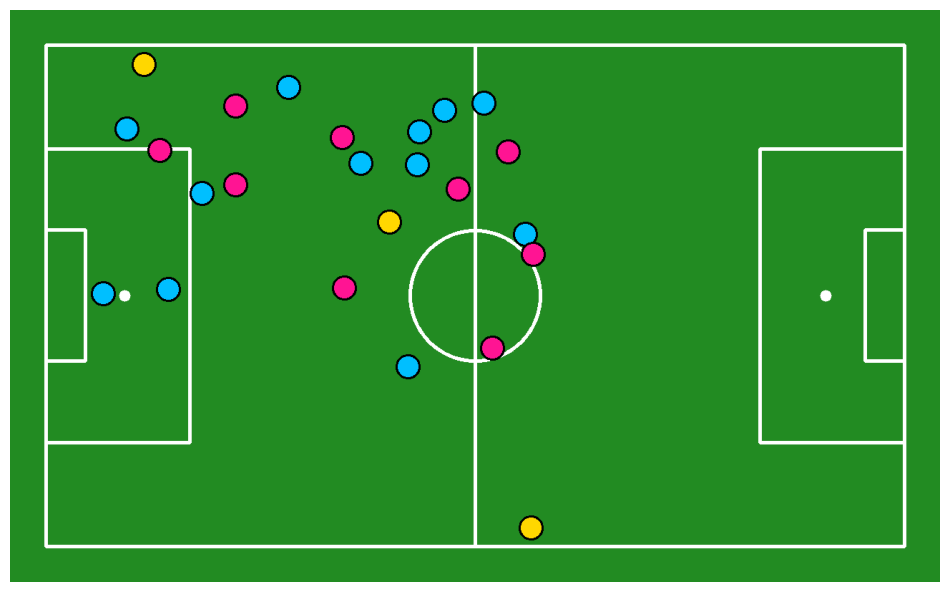

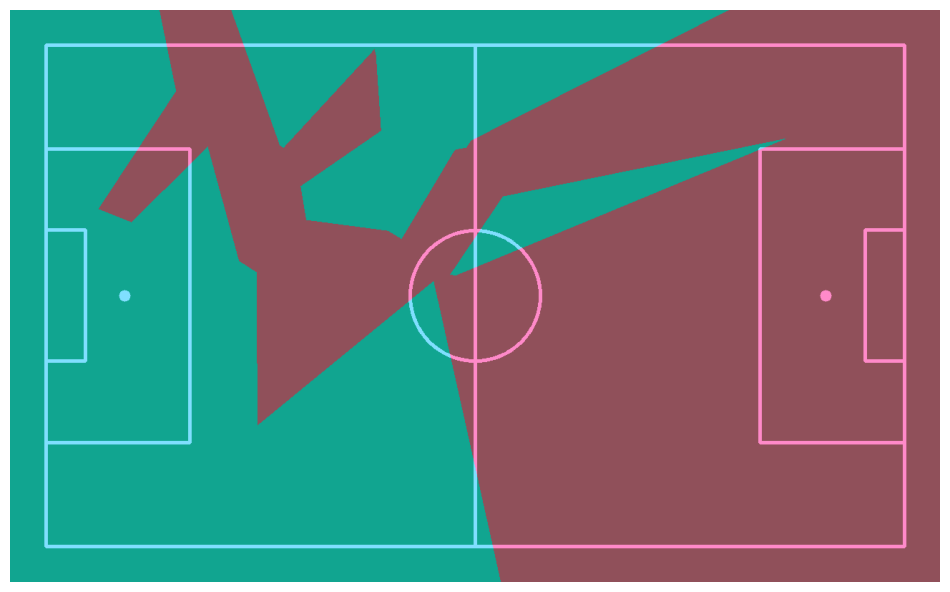

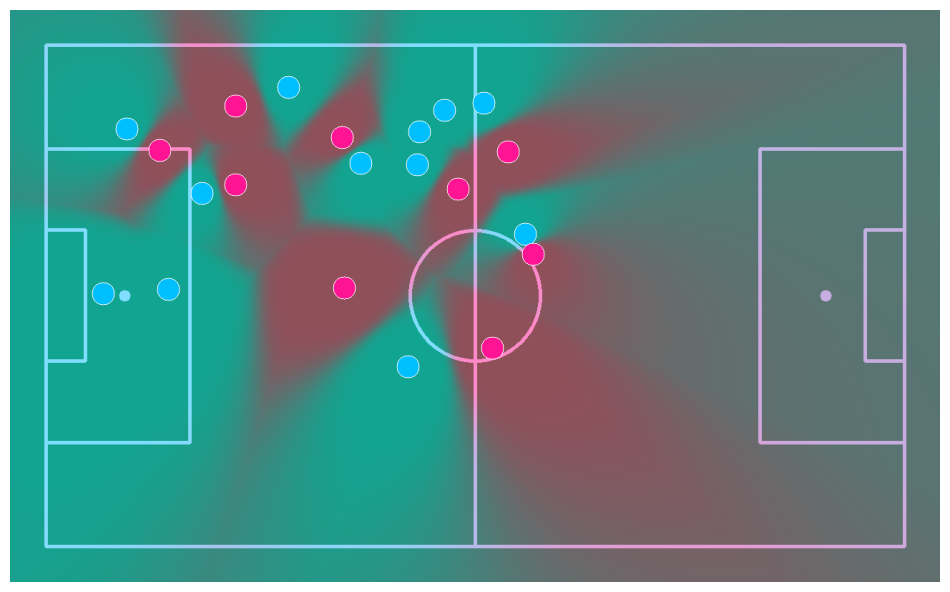

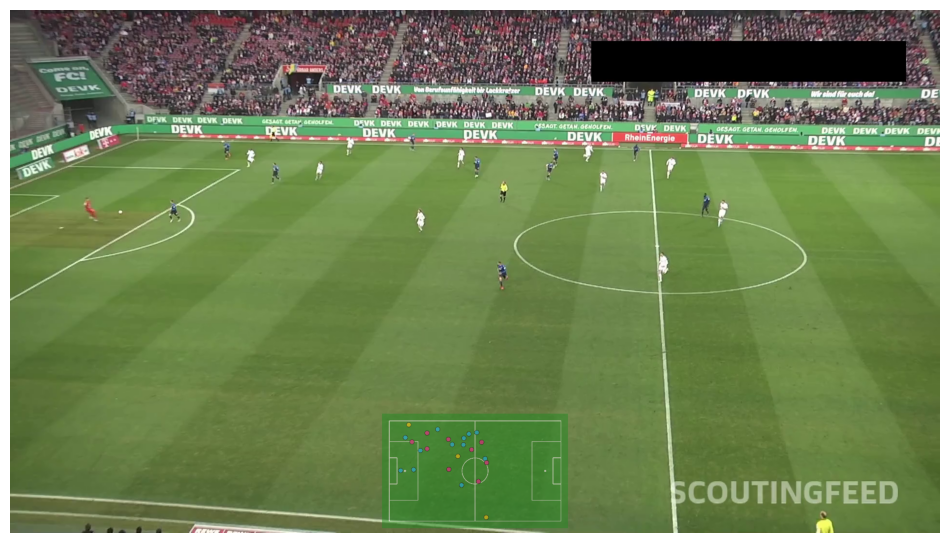

In [32]:
sv.plot_image(annotated_frame)
sv.plot_image(voronoi_frame)
sv.plot_image(blended_frame)
sv.plot_image(original_frame)

In [37]:
annotated_frame_1 = _draw_pitch()
voronoi_frame_1 = _draw_pitch()
blended_frame_1 = _draw_pitch()

# Draw Ball
annotated_frame_1 = _draw_points_on_pitch(xy=pitch_ball_xy,
                                            face_color=sv.Color.WHITE,
                                            edge_color=sv.Color.BLACK,
                                            radius=10,
                                            pitch=annotated_frame_1)

# Draw Players Team 1
annotated_frame_1 = _draw_points_on_pitch(xy=pitch_player_team1_xy,
                                            face_color=sv.Color.from_hex('00BFFF'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame_1)

# Draw Players Team 2
annotated_frame_1 = _draw_points_on_pitch(xy=pitch_player_team2_xy,
                                            face_color=sv.Color.from_hex('FF1493'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame_1)

# Draw Referees
annotated_frame_1 = _draw_points_on_pitch(xy=pitch_referee_xy,
                                            face_color=sv.Color.from_hex('FFD700'),
                                            edge_color=sv.Color.BLACK,
                                            radius=16,
                                            pitch=annotated_frame_1)

voronoi_frame_1 = _draw_pitch_voronoi_diagram(team_1_xy=pitch_player_team1_xy,
                                                team_2_xy=pitch_player_team2_xy,
                                                team_1_color=sv.Color.from_hex('00BFFF'),
                                                team_2_color=sv.Color.from_hex('FF1493'),
                                                pitch=voronoi_frame_1)



blended_frame_1 = _draw_pitch_voronoi_diagram_2(team_1_xy=pitch_player_team1_xy,
                                                        team_2_xy=pitch_player_team2_xy,
                                                        team_1_color=sv.Color.from_hex('00BFFF'),
                                                        team_2_color=sv.Color.from_hex('FF1493'),
                                                        pitch=blended_frame_1)

blended_frame_1 = _draw_points_on_pitch(xy=pitch_ball_xy,
                                        face_color=sv.Color.WHITE,
                                        edge_color=sv.Color.WHITE,
                                        radius=8,
                                        thickness=1,
                                        pitch=blended_frame_1)

blended_frame_1 = _draw_points_on_pitch(xy=pitch_player_team1_xy,
                                        face_color=sv.Color.from_hex('00BFFF'),
                                        edge_color=sv.Color.WHITE,
                                        radius=16,
                                        thickness=1,
                                        pitch=blended_frame_1)

blended_frame_1 = _draw_points_on_pitch(xy=pitch_player_team2_xy,
                                                face_color=sv.Color.from_hex('FF1493'),
                                                edge_color=sv.Color.WHITE,
                                                radius=16,
                                                thickness=1,
                                                pitch=blended_frame_1)

original_frame_1 = _overlay_minimap_on_frame(frame, annotated_frame_1, opacity=0.5, scale=0.2)


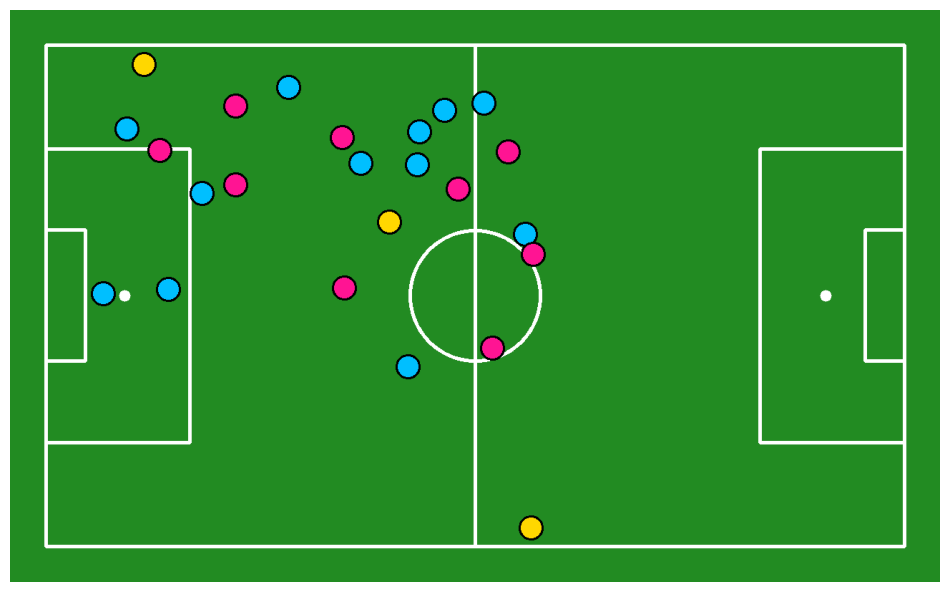

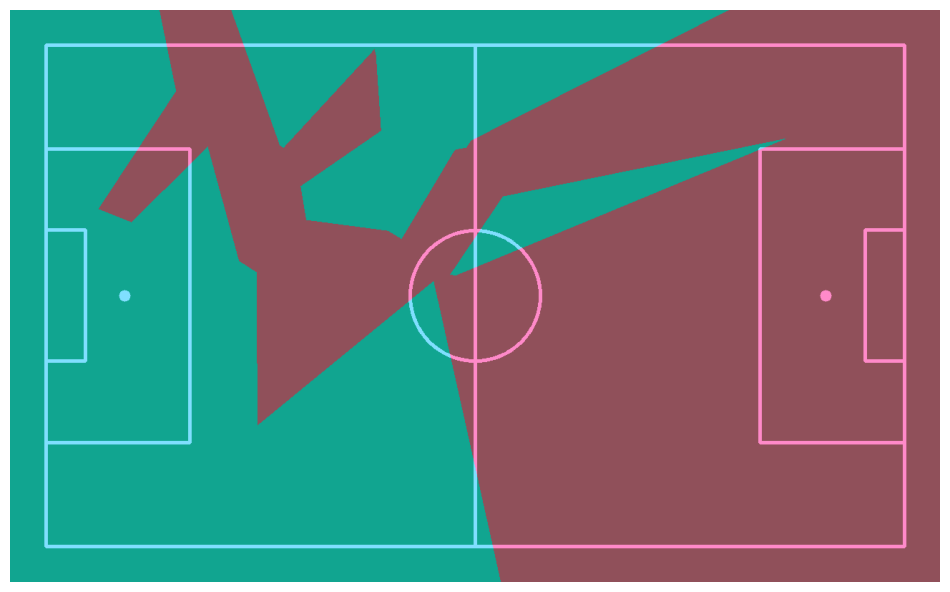

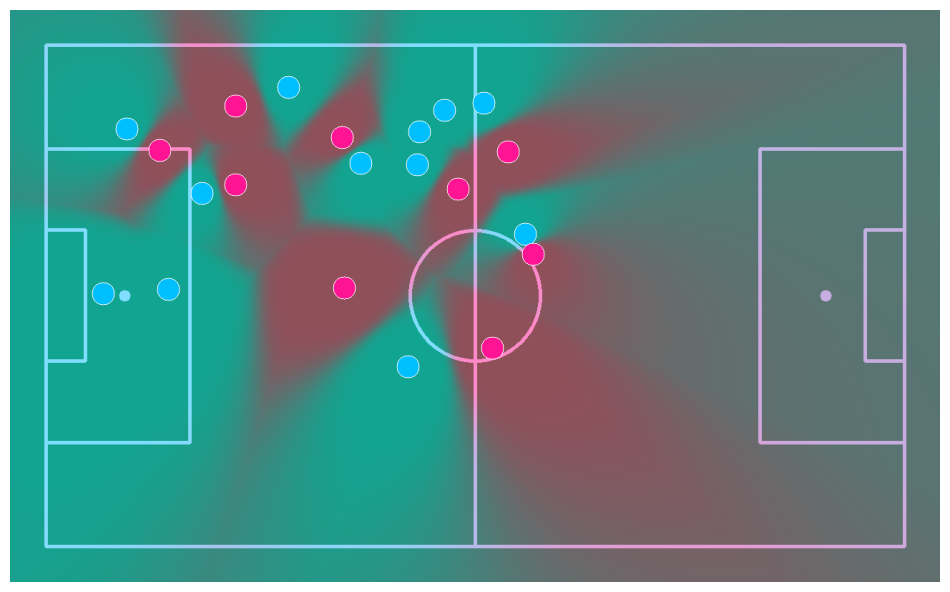

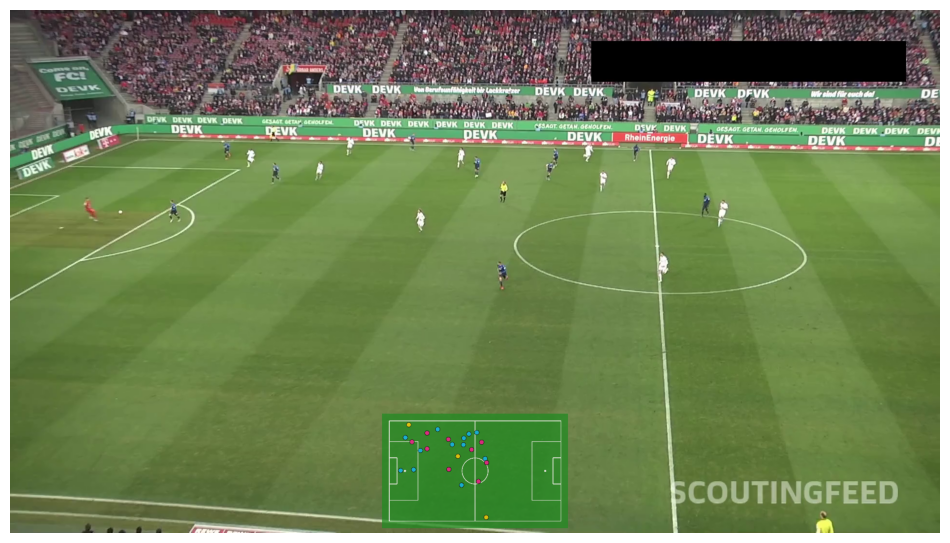

In [38]:
sv.plot_image(annotated_frame_1)
sv.plot_image(voronoi_frame_1)
sv.plot_image(blended_frame_1)
sv.plot_image(original_frame_1)

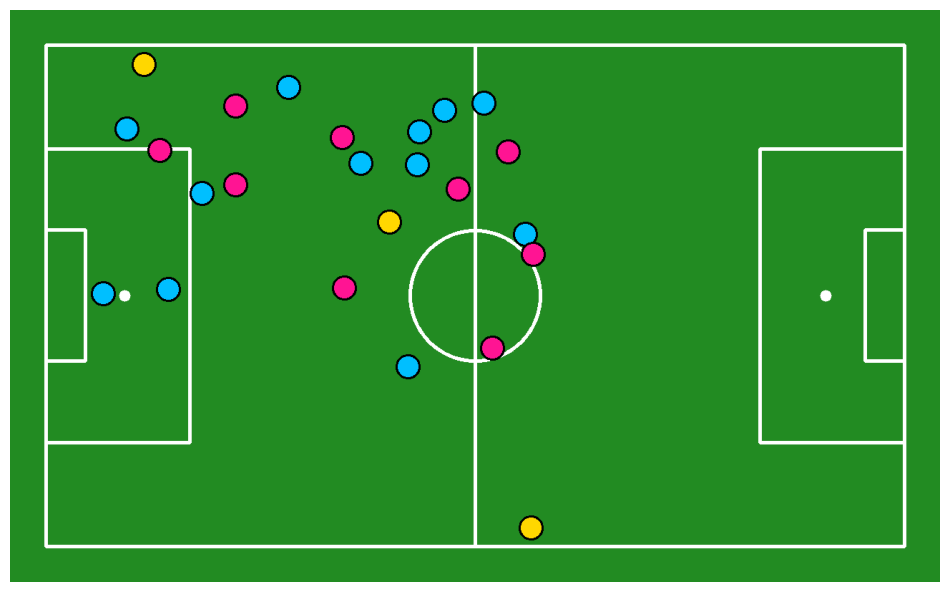

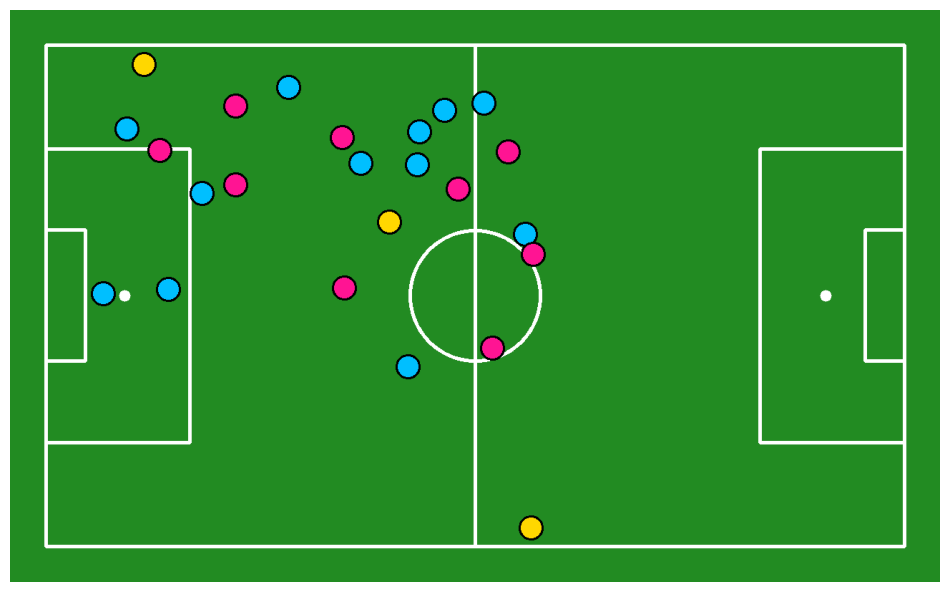

In [39]:
sv.plot_image(annotated_frame)
sv.plot_image(annotated_frame_1)